# Lab6 Clustering

This week's exercise will focus on clustering using two common algorithms, k-means and k-medoids

Schedule:
* Implement the core of k-means
* Clustering visualizations


## Reminders
* [GitHub repo](https://github.com/Faur/ITU-Data-Science-in-Games-Exercises)
* **Shut down notebooks** when you are done. Otherwise the server will run out of resources, and we will be forced to restart the them.
* Server storage is volatile! I.e. you must **save everything locally** that you don't want to loose.

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# BEFORE YOU START: Classification vs Clustering
Most of this excercise, specially the first part, will be very similar to the Lab4 Classification. This is because classification and clustering are similar concepts, but with a very important difference:

- Classification assigns labels from a pre-existing set
- Clustering groups togheter data by similarity

While k-nearest-neighbors returned somethin meaningful like 'GP' (GoalKeeper) and such, clustering algorithms will return something like '', 'Group1' or 'ClusterA'.
While after classification the task of the data scientist is to understant is the classification is *correct*, after clustering they need to understand if the clusters are *meaningful*, and what meaning those could have.


## Take a look at the data (again)

In [3]:
# Check that data and data path is present
basedir = "../"
file = "fifa.csv"
assert os.path.isdir(f"{basedir}data") and os.path.exists(f"{basedir}data/{file}"), 'Data not found. Make sure to have the most recent version!'

data = pd.read_csv(f'{basedir}/data/fifa.csv', sep=",")

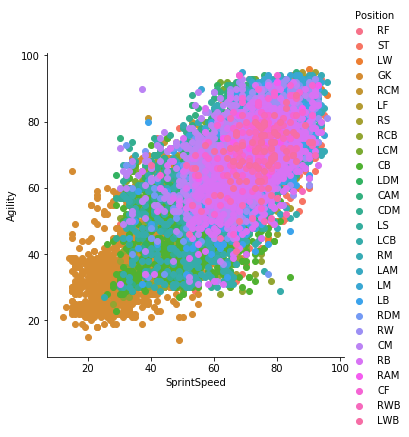

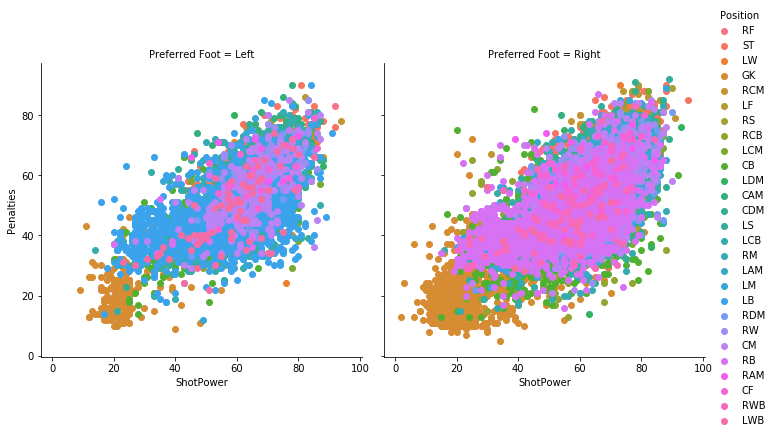

In [4]:
sns.FacetGrid(data, height=5,hue="Position").map(plt.scatter,"SprintSpeed","Agility").add_legend()
sns.FacetGrid(data, height=5,hue="Position", col='Preferred Foot').map(plt.scatter,"ShotPower",'Penalties').add_legend()

The scatter plots shows that the `Position` of a player could be related to some of their statistics. The dataset contains 30+ statistics and we don't know which ones will be most helpful, so we are picking an arbitrary subset to avoid the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).
It's also possible to choose the best ones [algorithmically](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Feature_extraction)

In [5]:
all_features = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
            'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina',
            'Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
            'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']

features = ["Aggression","Composure","Penalties",'SlidingTackle']
# cleaning: remove all the lines that contain a NaN in one of the feature columns
data = data.dropna(subset=features)

# K-means

0. pick a value for K (number of clusters)
1. normalize fields (in our case the data are already normalized)
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab4
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))

In [6]:
# 0: define K
K = 5

In [34]:
def k_means_clustering(data, max_iter=-1):
    ## YOUR CODE HERE
    centroids = pd.DataFrame(np.random.rand(K, len(features)) * 100, columns=features)

    def assign_centroid(x):
        x['Centroid'] = centroids.sub(x[features]) \
            .pow(2).sum(1).pow(0.5) \
            .idxmin(0)
        return x

    iter = 0
    data = data.assign(Centroid=pd.Series([-1] * len(data)), OldCentroid=pd.Series([0] * len(data)))
    while not data['Centroid'].equals(data['OldCentroid']):
        print(f'iter {iter}')
        
        data['OldCentroid'] = data['Centroid']
        data = data.apply(assign_centroid, axis=1)
        centroids = data.groupby('Centroid').mean()[features]
        centroids.reset_index()
        
        iter += 1
        if max_iter > -1 and iter >= max_iter:
            break
    
    print('done')
    return data[features+['Centroid']], centroids


In [35]:
new_data, new_centroids = k_means_clustering(data.head(10))

iter 0
iter 1
iter 2
done


In [36]:
new_data

,Aggression,Composure,Penalties,SlidingTackle,Centroid
0,48.0,96.0,75.0,26.0,1
1,63.0,95.0,85.0,23.0,1
2,56.0,94.0,81.0,33.0,1
3,38.0,68.0,40.0,13.0,2
4,76.0,88.0,79.0,51.0,1
5,54.0,91.0,86.0,22.0,1
6,62.0,84.0,82.0,73.0,0
7,87.0,85.0,85.0,38.0,1
8,88.0,82.0,75.0,91.0,0
9,34.0,70.0,11.0,18.0,2


In [37]:
new_centroids

,Aggression,Composure,Penalties,SlidingTackle
Centroid,,,,
0,75.0,83.0,78.500000,82.000000
1,64.0,91.5,81.833333,32.166667
2,36.0,69.0,25.500000,15.500000


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

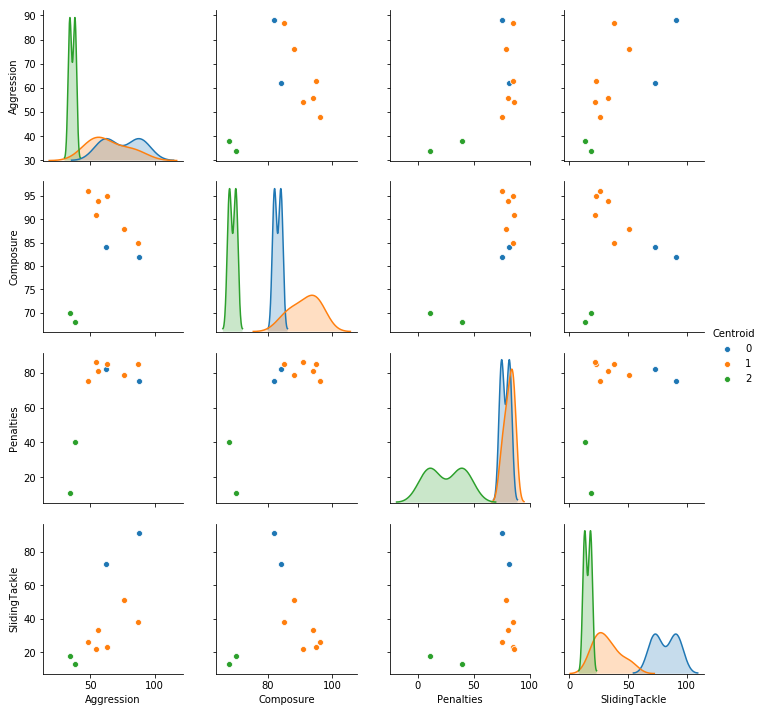

In [38]:
sns.pairplot(new_data, vars=features, hue='Centroid')